In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from elephant import kernels
from elephant import statistics
import quantities as pq
from quantities import s
import os
import neo
from dPCA import dPCA
from numpy.random import rand, randn, randint

## **Preprocessing: PSTH computation**

In [100]:
experiment3_files = [f for f in os.listdir(data_path) if (("t3" in f) or ("t1" in f)) ]


In [101]:
len(experiment3_files)

748

In [110]:
data_path="data3/"

#experiment3_files = [f for f in os.listdir(data_path) if (("t3" in f) or ("t1" in f)) ]



#generate an empty spike train to be used later for empty rate initialization
spiketrain0 = neo.SpikeTrain([0]*s, t_start=0,t_stop=7, units='s')
kernel = kernels.GaussianKernel(sigma=50 * pq.ms)

trial_df=[]
for filename in experiment3_files:
  
  #loading each tuple
  df=pd.read_csv(os.path.join(data_path+filename))
  
  if (not df.empty):
    #trial counter init
    trial_number=0
    
    #generate zero rate
    rate=np.zeros([7000,1])*pq.Hz
    
    for i in range(len(df)):
      #considering one trial at a time, converting data to suitable format for preprocessing using elephant
      
      df1=df.iloc[i,:]
      df1=df1.reset_index(drop=True)
      df1.index=df1.index*0.002
      df1=df1[df1==1]
      
      if (not df1.empty):
        #calculating PSTH for each trial
        trial_number+=1
        spiketrain = neo.SpikeTrain(df1.index*s, t_start=0,t_stop=7, units='s')
        rate += statistics.instantaneous_rate(spiketrain,sampling_period=1 * pq.ms,kernel=kernel)
  rate/=trial_number
  trial_df.append(trial_number)
  #Center data
  
  rate_mean=np.mean(rate)
  rate-=rate_mean
  
  np.save(os.path.join('data3/psth',filename[:-4]),rate)


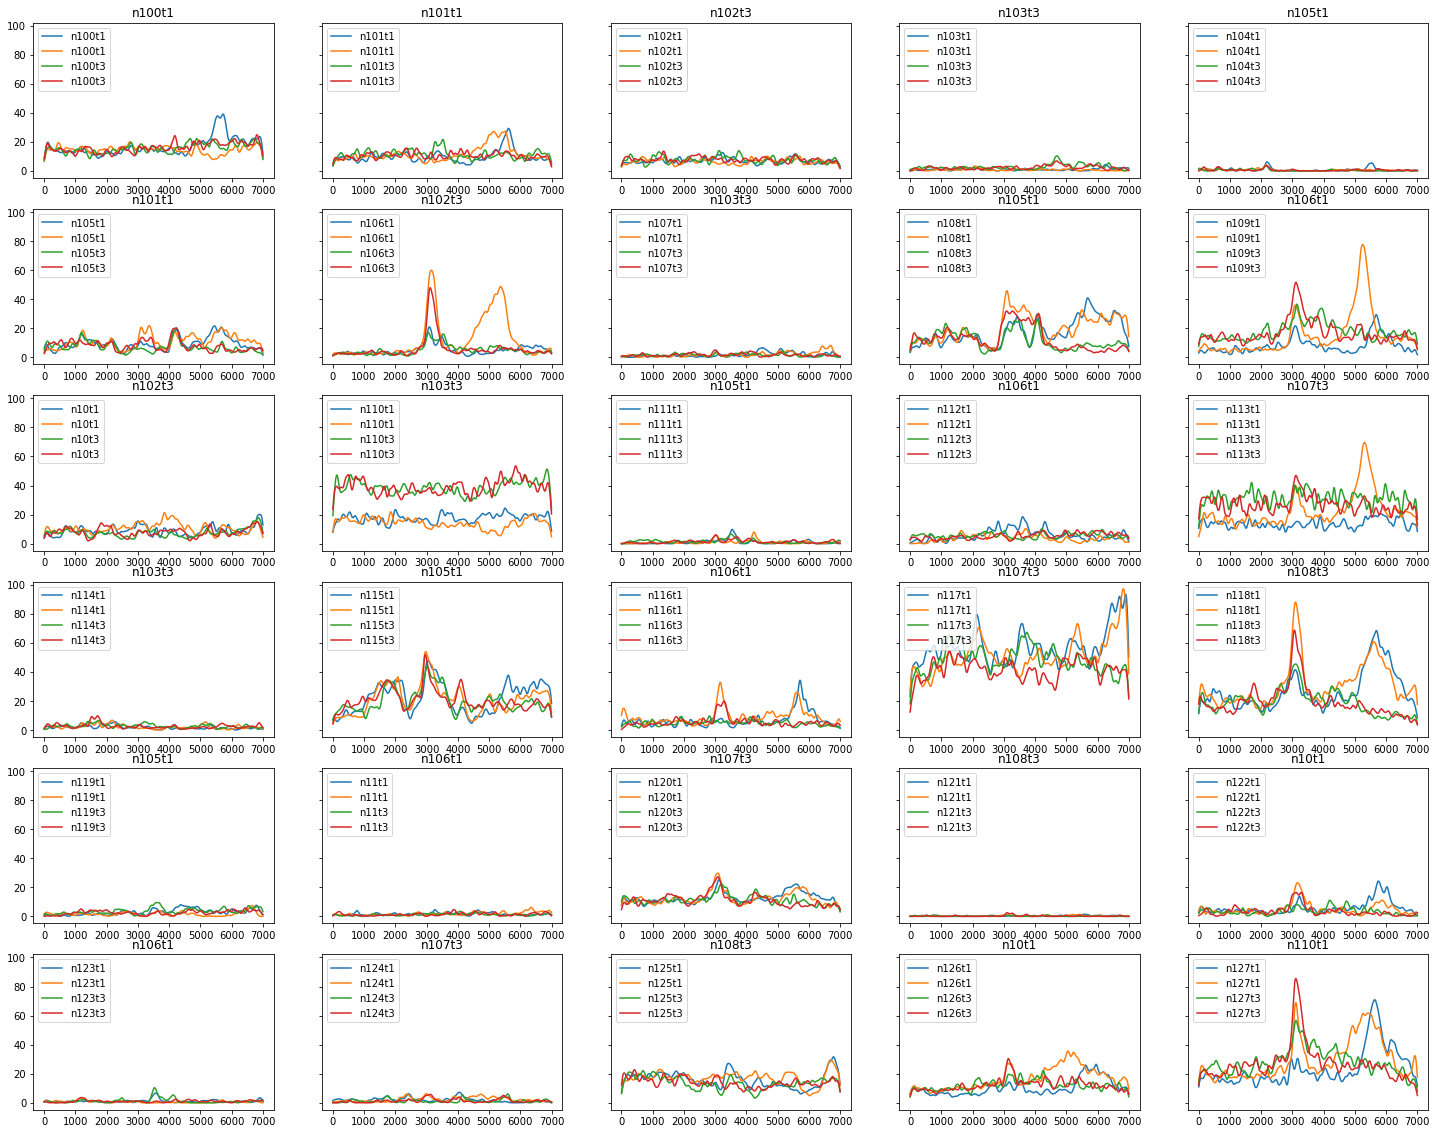

In [77]:
psth_path='/Users/machraouianas/Desktop/MPI TU/code/data3/psth/'
psth_files = [f[:-6] for f in sorted(np.unique(os.listdir(psth_path)))]
# Create two subplots and unpack the output array immediately
f, axs = plt.subplots(6, 5, sharey=True,figsize=(25,20))

counter=0
for i in range(len(axs)):
  for j in range(len(axs[0])):
    
    axs[i][j].plot(np.load(psth_path+psth_files[counter]+"c1.npy"),label=psth_files[counter])
    axs[i][j].legend(loc='upper left')
    axs[i][j].plot(np.load(psth_path+psth_files[counter+1]+"c2.npy"),label=psth_files[counter+1])
    axs[i][j].legend(loc='upper left')
    axs[i][j].set_title(psth_files[i*5+j])
    
    axs[i][j].plot(np.load(psth_path+psth_files[counter+2]+"c1.npy"),label=psth_files[counter+2])
    axs[i][j].legend(loc='upper left')
    axs[i][j].plot(np.load(psth_path+psth_files[counter+3]+"c2.npy"),label=psth_files[counter+3])
    axs[i][j].legend(loc='upper left')
    axs[i][j].set_title(psth_files[i*5+j*5])
    counter+=4
plt.show()


**Constructing big matrix X**

In [115]:
psth_path='/Users/machraouianas/Desktop/MPI TU/code/data3/psth/'
psth_files = [f[:-6] for f in sorted(np.unique(os.listdir(psth_path)))][1:]

In [116]:
#constructing the big matrix X
X=np.zeros((187,2,2, 7000))
counter=0
for f in range(len(X)):
  x1=np.load(psth_path+psth_files[counter]+"c1.npy").reshape(7000)
  x2=np.load(psth_path+psth_files[counter+1]+"c2.npy").reshape(7000)
  x3=np.load(psth_path+psth_files[counter+2]+"c1.npy").reshape(7000)
  x4=np.load(psth_path+psth_files[counter+3]+"c2.npy").reshape(7000)
    

  X[f][0,0]+=x1
  X[f][0,1]+=x2
  X[f][1,0]+=x3
  X[f][1,1]+=x4
  

  counter+=4
np.shape(X)

(187, 2, 2, 7000)

**dPCA part**



In [117]:
dpca = dPCA.dPCA(labels='sct')

In [118]:
Z = dpca.fit_transform(X)

In [119]:
np.shape(Z['sct'])

(10, 2, 2, 7000)

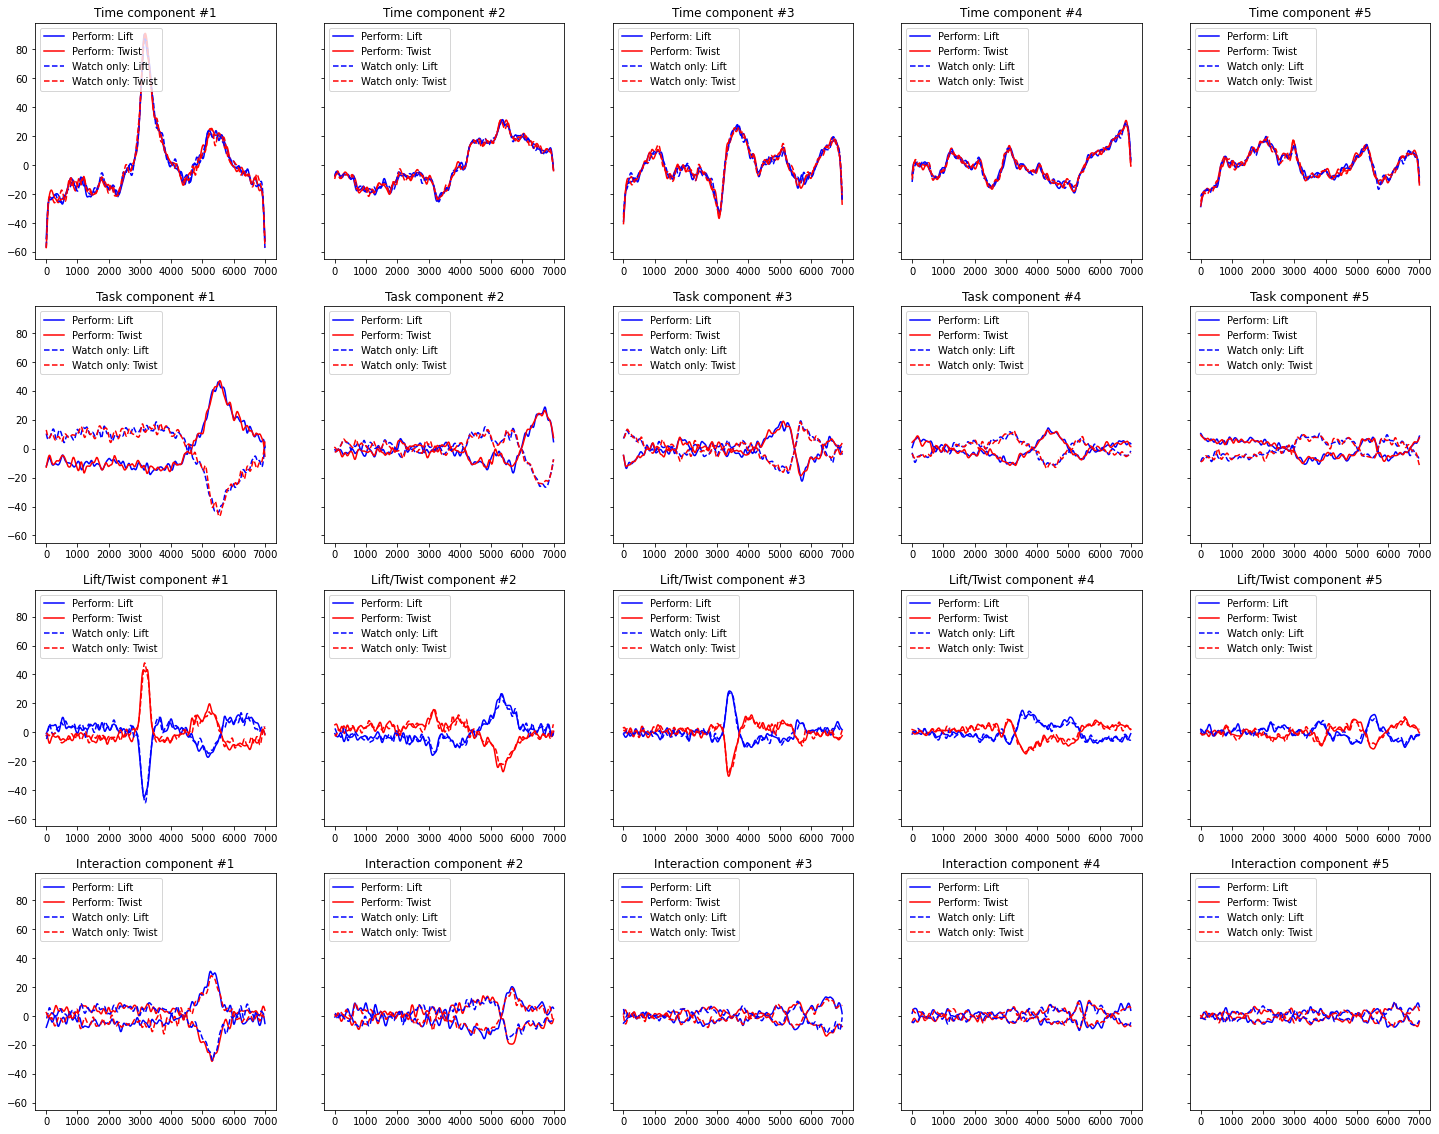

Variance Explained by the 1st dPCA TASK component: 9.852755670157766 %
Variance Explained by the 1st dPCA Condition component 3.6322425872467576 %
Variance Explained by the 1st dPCA TIME component 18.892730141260696 %
Variance Explained by the 1st dPCA INTERACTION component 2.398139984985772 %


In [156]:
time = np.arange(7000)

# Create two subplots and unpack the output array immediately
f, axs = plt.subplots(4, 5, sharey=True,figsize=(25,20))


for j in range(len(axs[0])):
    
    axs[0][j].plot(time,Z['t'][j][0,0],"b",label="Perform: Lift")
    axs[0][j].legend(loc='upper left')
    axs[0][j].plot(time,Z['t'][j][0,1],"r",label="Perform: Twist")
    axs[0][j].legend(loc='upper left')
    
    axs[0][j].plot(time,Z['t'][j][1,0],"b--",label="Watch only: Lift")
    axs[0][j].legend(loc='upper left')
    axs[0][j].plot(time,Z['t'][j][1,1],"r--",label="Watch only: Twist")
    axs[0][j].legend(loc='upper left')
    axs[0][j].set_title("Time component #"+str(j+1))
    
    axs[1][j].plot(time,Z['st'][j,0,0],"b",label="Perform: Lift")
    axs[1][j].legend(loc='upper left')
    axs[1][j].plot(time,Z['st'][j,0,1],"r",label="Perform: Twist")
    axs[1][j].legend(loc='upper left')
    
    axs[1][j].plot(time,Z['st'][j,1,0],"b--",label="Watch only: Lift")
    axs[1][j].legend(loc='upper left')
    axs[1][j].plot(time,Z['st'][j,1,1],"r--",label="Watch only: Twist")
    axs[1][j].legend(loc='upper left')
    axs[1][j].set_title("Task component #"+str(j+1))
    
    axs[2][j].plot(time,Z['ct'][j,0,0],"b",label="Perform: Lift")
    axs[2][j].legend(loc='upper left')
    
    axs[2][j].plot(time,Z['ct'][j,0,1],"r",label="Perform: Twist")
    axs[2][j].legend(loc='upper left')
    
    axs[2][j].plot(time,Z['ct'][j,1,0],"b--",label="Watch only: Lift")
    axs[2][j].legend(loc='upper left')
    
    axs[2][j].plot(time,Z['ct'][j,1,1],"r--",label="Watch only: Twist")
    axs[2][j].legend(loc='upper left')

    axs[2][j].set_title("Lift/Twist component #"+str(j+1))
    
    
    axs[3][j].plot(time,Z['sct'][j,0,0],"b",label="Perform: Lift")
    axs[3][j].legend(loc='upper left')
    
    axs[3][j].plot(time,Z['sct'][j,0,1],"r",label="Perform: Twist")
    axs[3][j].legend(loc='upper left')
    
    axs[3][j].plot(time,Z['sct'][j,1,0],"b--",label="Watch only: Lift")
    axs[3][j].legend(loc='upper left')
    
    axs[3][j].plot(time,Z['sct'][j,1,1],"r--",label="Watch only: Twist")
    axs[3][j].legend(loc='upper left')

    axs[3][j].set_title("Interaction component #"+str(j+1))
    
plt.savefig('1st_plot.png')
plt.show()
print("Variance Explained by the 1st dPCA TASK component:",
dpca.explained_variance_ratio_["st"][0]*100,'%')
"Variance Explained by the 1st dPCA CONDITION component:"
print("Variance Explained by the 1st dPCA Condition component",
dpca.explained_variance_ratio_["ct"][0]*100,'%')
print("Variance Explained by the 1st dPCA TIME component",dpca.explained_variance_ratio_["t"][0]*100,'%')
print("Variance Explained by the 1st dPCA INTERACTION component",dpca.explained_variance_ratio_["sct"][0]*100,'%')

In [31]:
a=dpca.explained_variance_ratio_["c"]*100+dpca.explained_variance_ratio_["t"]*100+dpca.explained_variance_ratio_["s"]*100

In [90]:
a=dpca.explained_variance_ratio_["c"]*100+dpca.explained_variance_ratio_["t"]*100+dpca.explained_variance_ratio_["s"]*100

In [155]:
print("Variance Explained by the 1st dPCA TASK component:",
dpca.explained_variance_ratio_["st"][0]*100,'%')
"Variance Explained by the 1st dPCA CONDITION component:"
print("Variance Explained by the 1st dPCA Condition component",
dpca.explained_variance_ratio_["ct"][0]*100,'%')
print("Variance Explained by the 1st dPCA TIME component",dpca.explained_variance_ratio_["t"][0]*100,'%')
print("Variance Explained by the 1st dPCA INTERACTION component",dpca.explained_variance_ratio_["sct"][0]*100,'%')

Variance Explained by the 1st dPCA TASK component: 9.852755670157766 %
Variance Explained by the 1st dPCA Condition component 3.6322425872467576 %
Variance Explained by the 1st dPCA TIME component 18.892730141260696 %
Variance Explained by the 1st dPCA INTERACTION component 2.398139984985772 %


In [139]:
"Variance Explained by the 1st dPCA TIME component"
dpca.explained_variance_ratio_["t"][0]*100

18.892730141260696

In [150]:
"Variance Explained by the 1st dPCA CONDITION component"

dpca.explained_variance_ratio_["c"][0]*100

3.9474250695588705e-59

In [151]:
dpca.explained_variance_ratio_["s"][0]*100

2.1649216408118285e-59

In [152]:
dpca.explained_variance_ratio_

{'s': [2.1649216408118285e-61,
  1.6512598857566033e-63,
  1.4226603977860422e-63,
  1.1210851748351486e-63,
  9.255902410044247e-64,
  7.38199364849403e-64,
  5.078924356570441e-64,
  4.7748823519815786e-64,
  3.686718930740544e-64,
  2.973289128046124e-64],
 'c': [3.9474250695588706e-61,
  8.433456720238541e-63,
  2.6033540021054396e-63,
  1.908857766749399e-63,
  1.3026502226452886e-63,
  1.0972649164944942e-63,
  7.797806184010514e-64,
  6.870354251627055e-64,
  5.12511495905611e-64,
  4.2029741063081297e-64],
 't': [0.18892730141260697,
  0.07811739708783234,
  0.048508130443373855,
  0.03606418647926584,
  0.02894973592683392,
  0.02884474162199147,
  0.015596221073205963,
  0.014956119655040817,
  0.00951485481490768,
  0.009268001072128688],
 'sc': [5.8944281677042156e-61,
  1.725886607160941e-62,
  1.0801189253804292e-62,
  5.44201969764802e-63,
  4.6804849504404263e-63,
  2.4862494351861804e-63,
  1.539652481483807e-63,
  1.2964933652785943e-63,
  1.1067244235738049e-63,
  8.

In [158]:
a=pd.read_pickle('/Users/machraouianas/Desktop/MPI TU/p_values_pickle.pickle')

In [165]:
filtered_neurons=[]
for index in a:
    if

0.0
0.0
0.0
0.014
0.124
0.575
0.066
0.0
0.0
0.905
0.427
0.0
0.0
0.73
0.0
0.0
0.0
0.99
0.0
0.2
0.0
0.014
0.0
0.0
0.0
0.0
0.799
0.183
0.0
0.0
0.007
0.0
0.0
0.0
0.467
0.318
0.89
0.856
0.673
0.031
0.0
0.805
0.0
0.0
0.0
0.0
0.0
0.539
0.031
0.036
0.019
0.831
0.0
0.308
0.197
0.0
0.0
0.001
0.769
0.001
0.001
0.037
0.009
0.175
0.033
0.066
0.0
0.0
0.331
0.167
0.395
0.007
0.0
0.0
0.0
0.006
0.0
0.141
0.0
0.0
0.008
0.016
0.0
0.0
0.569
0.0
0.029
0.314
0.804
0.0
0.0
0.556
0.0
0.057
0.0
0.0
0.011
0.165
0.0
0.006
0.026
0.001
0.0
0.205
0.094
0.425
0.065
0.048
0.0
0.0
0.029
0.01
0.0
0.668
0.921
0.721
0.0
0.023
0.006
0.001
0.0
0.168
0.81
0.0
0.096
0.0
0.0
0.004
0.002
0.63
0.09
0.196
0.01
0.854
0.89
0.109
0.427
0.49
0.67
0.0
0.969
0.0
0.261
0.183
0.0
0.398
0.255
0.483
0.644
0.0
0.387
0.109
0.0
0.199
0.005
0.0
0.039
0.245
0.0
0.0
0.0
0.255
0.0
0.742
0.9
0.0
0.0
0.0
0.57
0.014
0.748
0.546
0.023
0.853
0.0
0.038
0.0
0.815
0.465
0.033
0.404
0.0
0.008
0.592
0.0
0.085
0.0
